# HW4_1
# NO:711133112, NAME: 徐騫諒

### 本次目的：利用 PyTorch 深度機器學習 CNN 模型進行 Yale Face 人臉辨識。其中 CNN 模型與訓練等相關參數自行設定，以達到測試資料的辨識準確率最高為目的。最後並寫一段程式實際對已訓練完成的 CNN 模型（讀入 pre-trained pth 檔）輸入任何一張測試影像，並列印出所辨識的人臉 Label。

## Import necessary libraries

In [77]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import scipy.io

## Load and prepare yale-face data 

In [78]:
D = scipy.io.loadmat('/Users/liang/Downloads/allFaces.mat')
X = D['faces'].T #32256*2410 each column represents an image 
# y = np.ndarray.flatten(D['nfaces'])#分別代表每個人的張數
m = int(D['m'])#168
n = int(D['n'])#192
n_persons = int(D['person'])#38個人
counts = [64, 62, 64, 64, 62, 64, 64, 64, 64, 64, 60, 59, 60, 63, 62, 63,
        63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64]  # 從 64 到 38 遞減
y = np.repeat(np.arange(38), counts)

### Transe orginal data to tensor data

把資料及切割為0.7的訓練部分與 0.3 的測試資料，並選擇 batch size = 64

In [79]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25
X_train=X_train.reshape(-1,1,168,192) 
X_test=X_test.reshape(-1,1,168,192)
X_train=np.transpose(X_train,(0,1,3,2))
X_test=np.transpose(X_test,(0,1,3,2))
# prepare data for PyTorch Tensor
X_train = torch.from_numpy(X_train).float() # convert to float tensor
y_train = torch.from_numpy(y_train).long() # 
train_dataset = TensorDataset(X_train, y_train) # create your datset
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
test_dataset = TensorDataset(X_test, y_test) # create your datset
 
# create dataloader for PyTorch
batch_size = 64 # 32, 64, 128, 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # convert to dataloader
test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)

## Define the network (max poolong)

定義了一個名為 `Net` 的神經網路模型，它包含了卷積層、批量正規化層和全連接層。

- `self.conv1 = nn.Conv2d(1, 6, 5, padding=2)`：定義了第一個卷積層，因為此資料為黑白圖片所以輸入通道數為1，輸出通道數為6，選取 kernel size 卷積核大小為5x5，並進行了2個單位的填充操作，且填補方式為補上0。
- `self.bc1 = nn.BatchNorm2d(6)`：定義了第一個卷積層後的批量正規化層，用於對輸出進行正規化處理，加速模型收斂。
- `self.conv2 = nn.Conv2d(6, 16, 5, padding=2)`：定義了第二個卷積層，輸入通道數為6，輸出通道數為16，選取 kernel size 卷積核大小為5x5，並進行了2個單位的填充操作，且填補方式為補上0。
- `self.bc2 = nn.BatchNorm2d(16)`：定義了第二個卷積層後的批量正規化層，用於對輸出進行正規化處理，加速模型收斂。
- `self.fc1 = nn.Linear(16 * 48 * 42, 120)`：定義了第一個全連接層，將經過卷積和池化後的特徵圖展平成一維張量，並將其映射到大小為120的特徵空間。
- `self.fc2 = nn.Linear(120, 84)`：定義了第二個全連接層，將特徵空間映射到大小為84的特徵空間。
- `self.fc3 = nn.Linear(84, 38)`：定義了最後一個全連接層，將特徵空間映射到大小為38的特徵空間，作為最終的輸出。
- `max pooling=2(or (2,2))`:可以降低尺寸，Max pooling通過選取每個區域內的最大值，將特徵圖的尺寸縮小。這有助於減少模型中的參數數量和計算量，同時保留主要的特徵信息，這邊選擇在 2*2的區域選取最大的值做替代。

In [95]:
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5,padding=2) # 1 input channel, 6 output channels, 5x5 square convolution
        self.bc1=nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5,padding=2) # 6 input channel, 16 output channels, 5x5 square convolution
        self.bc2=nn.BatchNorm2d(16)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 48 * 42, 120)  # 4*4 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38) # 10 output classes
 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.bc1(self.conv1(x))), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.bc2(self.conv2(x))), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
)


## 觀察將進入訓練的影像資料，並試做 network 是否設計有誤

(1, 38)
tensor([[ 0.0671,  0.1192, -0.0730, -0.0030, -0.0222,  0.1097,  0.0665, -0.0562,
         -0.0523, -0.1599, -0.1890, -0.0567,  0.0833,  0.0404,  0.0938,  0.0449,
         -0.1722, -0.1386, -0.0665,  0.0273,  0.1114,  0.0347,  0.1005,  0.1161,
          0.0399, -0.0412,  0.0910, -0.0933,  0.1333, -0.0276,  0.0165, -0.0872,
          0.0169, -0.0227,  0.0240,  0.0515,  0.0475,  0.1010]])
tensor([[28]])
[[ 0.06705383  0.11922588 -0.07304453 -0.0030148  -0.02217329  0.10968576
   0.06646384 -0.05619514 -0.05229098 -0.1599015  -0.18897551 -0.05668456
   0.08328578  0.04038238  0.09377917  0.0448717  -0.17220756 -0.13862178
  -0.06650265  0.02733481  0.1114309   0.0346861   0.10051775  0.11609032
   0.03988185 -0.04123143  0.09098262 -0.09334645  0.13331205 -0.02758605
   0.01647708 -0.08719327  0.01694394 -0.02274794  0.02400051  0.05153255
   0.04748929  0.10100294]]
torch.Size([64, 1, 192, 168])


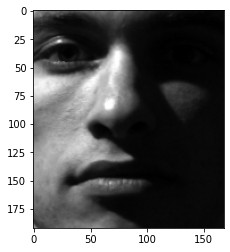

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


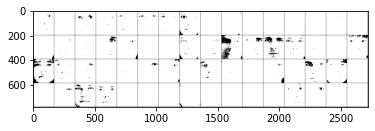

In [96]:
input = train_dataset[0][0].reshape(1, 1, 192, 168)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()

## Define a Loss function and optimizer: use a Classification Cross-Entropy loss and Adam with momentum

使用交叉熵損失函數nn.CrossEntropyLoss()作為損失函數，以及Adam優化器torch.optim.Adam()作為優化器。雖然說
Adam (Adaptive Moment Estimation) 和 SGD (Stochastic Gradient Descent) 都是深度學習中常用的優化算法，用於更新模型參數以最小化損失函數。

但SGD 是一種基本的優化算法，每次更新時使用小批量樣本的梯度來調整模型參數。它計算損失函數對於每個參數的梯度，然後按照一個固定的學習率乘以梯度的負方向來更新參數。SGD 可能會遇到局部極小值和不穩定的問題，但它計算簡單且具有較小的記憶體需求。

而Adam 優化器結合了自適應學習率和動量的概念，旨在提高優化的速度和效果。它綜合考慮了梯度的一階矩估計（平均梯度）和二階矩估計（梯度的無偏平方估計），並使用動量項來加速優化過程。Adam 優化器自適應地調整學習率，對於每個參數都維護了自己的學習率，使得每個參數都可以以不同的速度進行更新。Adam 優化器在許多情況下能夠快速收斂並獲得良好的結果。

總結來說，Adam 優化器具有自適應學習率和動量的優點，可以更快地收斂並適應不同的參數更新速度；而 SGD 優化器則是一種簡單且易於實現的基本優化算法。選擇哪一種優化器取決於具體的問題和實驗需求。此次實驗由十時間上的考量所以選擇 Adam 優化器來做以下實驗。

In [97]:
net=Net()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-4)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

## Train the network

In [98]:
epochs = 50
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 20 == 9:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
 
# print('Finished Training')

[epoch : 1, batch:    10] loss: 3.775
[epoch : 2, batch:    10] loss: 1.108
[epoch : 3, batch:    10] loss: 0.206
[epoch : 4, batch:    10] loss: 0.106
[epoch : 5, batch:    10] loss: 0.044
[epoch : 6, batch:    10] loss: 0.038
[epoch : 7, batch:    10] loss: 0.031
[epoch : 8, batch:    10] loss: 0.033
[epoch : 9, batch:    10] loss: 0.025
[epoch : 10, batch:    10] loss: 0.015
[epoch : 11, batch:    10] loss: 0.013
[epoch : 12, batch:    10] loss: 0.014
[epoch : 13, batch:    10] loss: 0.006
[epoch : 14, batch:    10] loss: 0.010
[epoch : 15, batch:    10] loss: 0.012
[epoch : 16, batch:    10] loss: 0.007
[epoch : 17, batch:    10] loss: 0.014
[epoch : 18, batch:    10] loss: 0.007
[epoch : 19, batch:    10] loss: 0.007
[epoch : 20, batch:    10] loss: 0.003
[epoch : 21, batch:    10] loss: 0.007
[epoch : 22, batch:    10] loss: 0.007
[epoch : 23, batch:    10] loss: 0.004
[epoch : 24, batch:    10] loss: 0.006
[epoch : 25, batch:    10] loss: 0.010
[epoch : 26, batch:    10] loss: 0

## Save the trained model for later use: 
做為再次訓練的起點或訓練完成後的使用狀態，把訓練完的模型存起來方便以後要用到的時候就不需重新再訓練一次


In [99]:
PATH = '/Users/liang/Documents/NTPU/Shallow_ML/SRCNN/src/outputs/cnn_yaleface.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

叫出訓練完的模型準備應用在測試資料上

In [100]:
new_model = Net()  
new_model.load_state_dict(torch.load('/Users/liang/Documents/NTPU/Shallow_ML/SRCNN/src/outputs/cnn_yaleface.pt'))
new_model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
)

## Test the network on the test data

可觀測出藉由訓練好的 CNN 模型，應用在測試資料集上正確率高達 96% 。說明 CNN 這個深度學習的模型是個不錯的模型。

In [101]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the  test images: {100 * correct // total} %')

Accuracy of the network on the  test images: 96 %


## Network Without max pooling
以下的部分是更改 CNN 裡面的模型，把 Max pooling （池化）的地方拿掉。因為我看了一些文獻發現不做 Max pooling 有以下幾個好處：

1. 保留更多的細節信息：最大池化操作會將區域內的最大值保留下來，同時丟棄其他特徵。如果不進行最大池化，則可以保留更多的細節信息，因為沒有信息被選擇性地丟棄。

2. 減少特徵降採樣：最大池化通常用於降低特徵圖的尺寸，從而減少計算量。然而，在某些場景中，尺寸的減小可能會導致信息的損失。如果不使用最大池化，可以避免過度降低特徵圖的尺寸，從而減少信息的丟失。

3. 更精細的定位能力：最大池化操作可能會導致特徵的位置信息模糊。如果不進行最大池化，可以保留更多的位置信息，從而提供更好的特徵定位能力。

4. 適用於小尺寸圖像：在某些情況下，如果輸入圖像的尺寸較小，進行最大池化可能會導致特徵的過度壓縮。在這種情況下，不使用最大池化可以保留更多的特徵信息，從而提高模型的性能。

需要注意的是，不使用最大池化也可能導致一些問題，例如模型的計算量增加、過度擬合等。所以為了提高正確率，我嘗試把 Max pooling 拿掉。

In [87]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.bc1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        self.bc2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 192 * 168, 120)

        # self.fc1 = nn.Linear(16 * 48 * 42, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38)

    def forward(self, x):
        x = F.relu(self.bc1(self.conv1(x)))
        x = F.relu(self.bc2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=516096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
)


Define a Loss function and optimizer: use a Classification Cross-Entropy loss and SGD with momentum

In [88]:
net=Net()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-4)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

Train the network

In [89]:
epochs = 50
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 20 == 9:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
 
print('Finished Training')

[epoch : 1, batch:    10] loss: 25.740
[epoch : 2, batch:    10] loss: 2.404
[epoch : 3, batch:    10] loss: 0.574
[epoch : 4, batch:    10] loss: 0.196
[epoch : 5, batch:    10] loss: 0.053
[epoch : 6, batch:    10] loss: 0.032
[epoch : 7, batch:    10] loss: 0.028
[epoch : 8, batch:    10] loss: 0.016
[epoch : 9, batch:    10] loss: 0.031
[epoch : 10, batch:    10] loss: 0.008
[epoch : 11, batch:    10] loss: 0.017
[epoch : 12, batch:    10] loss: 0.010
[epoch : 13, batch:    10] loss: 0.012
[epoch : 14, batch:    10] loss: 0.013
[epoch : 15, batch:    10] loss: 0.014
[epoch : 16, batch:    10] loss: 0.005
[epoch : 17, batch:    10] loss: 0.006
[epoch : 18, batch:    10] loss: 0.005
[epoch : 19, batch:    10] loss: 0.005
[epoch : 20, batch:    10] loss: 0.004
[epoch : 21, batch:    10] loss: 0.014
[epoch : 22, batch:    10] loss: 0.003
[epoch : 23, batch:    10] loss: 0.006
[epoch : 24, batch:    10] loss: 0.006
[epoch : 25, batch:    10] loss: 0.003
[epoch : 26, batch:    10] loss: 

save the trained model for later use: 做為再次訓練的起點或訓練完成後的使用狀態

In [90]:
PATH = '/Users/liang/Downloads/cnn_yaleface_practice.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

In [91]:
new_model = Net()  
new_model.load_state_dict(torch.load('/Users/liang/Downloads/cnn_yaleface_practice.pt'))
new_model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=516096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
)

## Test the network on the test data
可觀測到拿掉 Max pooling 後，正確率從 96% 提升到97% ，提升的幅度不到，可能是有幾個原因：

1. 網絡架構：網絡架構的設計非常重要，並且需要綜合考慮數據集特點和任務要求。最大池化操作通常用於降低特徵圖的尺寸並提取最重要的特徵。如果移除最大池化操作後，網絡架構中其他組件（如卷積層、全連接層）無法充分提取並學習到足夠的特徵，那麼性能可能無法得到顯著提升。

2. 模型過擬合：移除最大池化操作可能增加了模型的容量，使其更容易過擬合訓練數據。如果模型在訓練集上的正確率已經非常高，但在測試集上的正確率提升有限，則可能存在過擬合的問題。在這種情況下，可能需要進一步調整模型的正則化手段，如增加 Dropout 或 L2 正則化等。

總的來說，移除最大池化操作並不能保證在所有情況下都能提高模型的性能。它需要在合適的數據集和網絡架構下進行評估和調整，以達到更好的效果。

In [92]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the  test images: {100 * correct // total} %')


Accuracy of the network on the  test images: 97 %


## 寫一段程式實際對已訓練完成的 CNN 模型（讀入 pre-trained pth 檔）輸入任何一張測試影像，並列印出所辨識的人臉 Label。

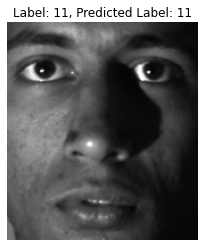

In [102]:
mages, labels = next(iter(test_loader))
index = np.random.randint(len(images))
image = images[index]
label = labels[index]

with torch.no_grad():
    output = new_model(image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

image_np = image.squeeze().numpy()
plt.imshow(image_np, cmap = 'gray')
plt.title(f"Label: {label.item()}, Predicted Label: {predicted_label.item()}")
plt.axis('off')
plt.show()

由上圖可觀測出，經由我們訓練的 CNN 模型，可以正確辨識人臉資料，此圖為第 11 個人的人臉資料。